In [1]:
import os
import shutil # 고수준 연산 제공, 파일 복사 삭제
import zipfile
import math
import pathlib
import time

import numpy as np
import pandas as pd
#import cv2 
import PIL
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

# 1. 데이터 분석 (EDA)
https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria 로부터 데이터를 다운로드하고 주피터 환경에 업로드합니다. 압축파일을 풀고, 프로젝트에 필요하지 않은 데이터 폴더는 지웁니다.

In [2]:
os.getcwd()

'C:\\Users\\freew\\elice\\Malaria'

In [3]:
if not os.path.exists('./cell_images'):
# if not os.path.exists('/mnt/data/cell_images'):
    start_time = time.time()
    malaria_zip = zipfile.ZipFile('archive.zip') # zip file 열기
    malaria_zip.extractall('./') #unzip zip file
    malaria_zip.close()
    elapsed_time = time.time() - start_time # zip file 여는 시간
    print("Elapsed Time (unzip): {}".format(elapsed_time))
    
if os.path.exists('./cell_images/cell_images'):
    start_time = time.time()
    shutil.rmtree('./cell_images/cell_images')
    elapsed_time = time.time() - start_time
    print("Elapsed Time (rm -r cell_images): {}".format(elapsed_time))

말라이아 감염 세포 이미지들이 있는 Parasitized 폴더와 정상 세포 이미지들이 포함되어 있는 Uninfected 폴더에 있는 이미지들의 개수를 확인합니다.

In [4]:
# listdir: 디렉토리에 있는 항목들의 이름을 담고 있는 리스트 반환
parasitized_list = os.listdir('./cell_images/Parasitized')
uninfected_list = os.listdir('./cell_images/Uninfected')

In [5]:
print('The number of parasitizedlen images : {}'.format(len(parasitized_list)))
print('The number of unifected images      : {}'.format(len(uninfected_list)))

The number of parasitizedlen images : 13780
The number of unifected images      : 13780


감염 세포와 정상 세포 이미지를 확인합니다.

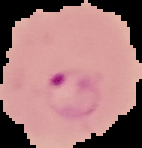

In [6]:
PIL.Image.open(os.path.join('./cell_images/Parasitized',parasitized_list[0]))

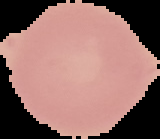

In [7]:
PIL.Image.open(os.path.join('./cell_images/Uninfected', uninfected_list[0]))

모델에 입력으로 들어갈 이미지의 크기와 한 번의 iteration에 모델에 넣어줄 batch 사이즈(이미지 개수)를 설정합니다.

In [8]:
train_malaria = pd.read_csv('csv/train_malaria_imbalanced_20.csv')
val_malaria = pd.read_csv('csv/val_malaria.csv')

In [9]:
train_malaria

,Path,ClassId
0,/mnt/data/cell_images/Uninfected/C155P116ThinF...,Uninfected
1,/mnt/data/cell_images/Uninfected/C49P10thinF_I...,Uninfected
2,/mnt/data/cell_images/Uninfected/C209ThinF_IMG...,Uninfected
3,/mnt/data/cell_images/Uninfected/C222ThinF_IMG...,Uninfected
4,/mnt/data/cell_images/Uninfected/C189P150ThinF...,Uninfected
...,...,...
9961,/mnt/data/cell_images/Parasitized/C129P90ThinF...,Parasitized
9962,/mnt/data/cell_images/Parasitized/C137P98ThinF...,Parasitized
9963,/mnt/data/cell_images/Uninfected/C236ThinF_IMG...,Uninfected
9964,/mnt/data/cell_images/Parasitized/C99P60ThinF_...,Parasitized


<BarContainer object of 2 artists>

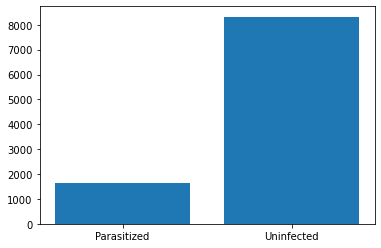

In [10]:
dict_train_malaria = {}

for cell in ['Parasitized', 'Uninfected']:
    dict_train_malaria[cell] = 0

for cell in train_malaria['ClassId']:
    dict_train_malaria[cell] += 1

plt.bar(dict_train_malaria.keys(), dict_train_malaria.values())

## 2. 데이터 전 처리

##### [assignment 1] train_datagen을 변경하여 학습해보기

train data와 validation data로 나눕니다. 이 과정에서 tensorflow.keras 패키지에서 제공하는 함수를 사용합니다. tf.keras.preprocessing.image.ImageDataGenerator는 기본적인 데이터 augmentation 기법을 제공합니다. 이미지 전처리 기법도 모델의 최종 성능을 높이는 좋은 방법입니다.

In [11]:
img_height = 128
img_width  = 128
batch_size = 32

In [12]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale = 1./255,
        horizontal_flip = True,
        vertical_flip = True
#         brightness_range = [0.7,1.3],
#         zoom_range = [0.5,1.5],
#         rotation_range = 90)
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe   = train_malaria ,
        directory   = 'data',
        x_col       = 'Path', 
        y_col       = 'ClassId',
        target_size = (img_height, img_width),
        batch_size  = batch_size,
        class_mode  = 'binary')

val_generator = val_datagen.flow_from_dataframe(
        dataframe   = val_malaria,
        directory   = 'data',
        x_col       = 'Path',
        y_col       = 'ClassId',
        target_size = (img_height, img_width),
        batch_size  = batch_size,
        shuffle     = False,
        class_mode  = 'binary')

Found 9966 validated image filenames belonging to 2 classes.
Found 5512 validated image filenames belonging to 2 classes.


In [13]:
data_classes = train_generator.class_indices
num_classes = len(data_classes)
print('class: {}'.format(data_classes))

class: {'Parasitized': 0, 'Uninfected': 1}


In [14]:
for image_batch, labels_batch in train_generator:
    print(labels_batch)
    break

[1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 0. 0.]


In [15]:
for image_batch, labels_batch in val_generator:
    print(labels_batch)
    break

[1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 1. 0. 0. 1. 1. 0. 0. 0.]


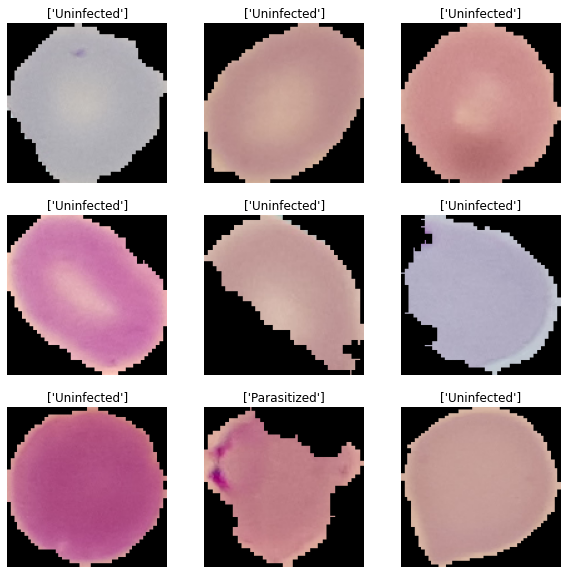

In [16]:
plt.figure(figsize=(10, 10))
images, labels = train_generator[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    key = [key for key, value in data_classes.items() if value  == labels[i]]
    plt.title(key)
    plt.axis("off")

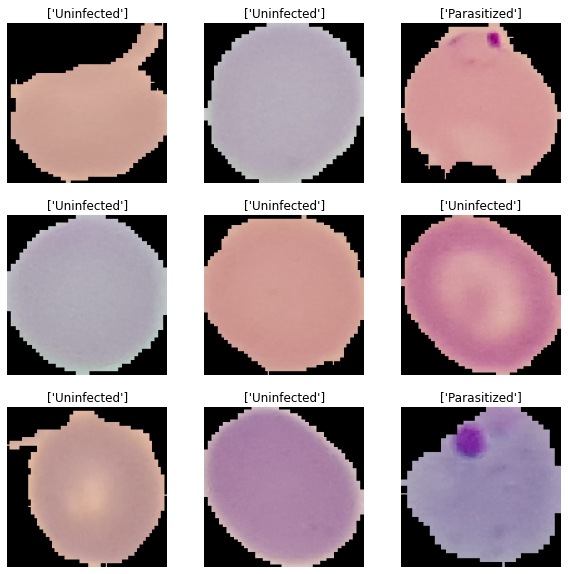

In [17]:
plt.figure(figsize=(10, 10))
images, labels = val_generator[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    key = [key for key, value in data_classes.items() if value  == labels[i]]
    plt.title(key)
    plt.axis("off")

## 3. Convolutional Neural Network (CNN) 모델

model.summary()는 모델의 구성을 한 눈에 확인할 수 있게 도와줍니다.

##### [assignment 2] 모델 구조를 수정해보기

In [22]:
from tensorflow.keras.applications import DenseNet121


model = models.Sequential()
model.add(DenseNet121(
    include_top=False, weights='imagenet',
    input_shape=(img_height, img_width, 3), pooling='max'
))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(num_classes, activation='softmax'))


model.summary()

33193984/33188688 [==============================] - 123s 4us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1000)              8062504   
_________________________________________________________________
dense (Dense)                (None, 64)                64064     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 8,126,954
Trainable params: 8,043,178
Non-trainable params: 83,776
_________________________________________________________________


### https://www.tensorflow.org/api_docs/python/tf/keras/Model

##### [assignment 3] optimizer 변경해보기

In [27]:
opt = tf.keras.optimizers.Adam(lr=0.001) 

model.compile(optimizer=opt, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs=10

학습 전 weight

In [28]:
print(model.layers[0].get_weights()) #before training

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [29]:
# callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
#              tf.keras.callbacks.ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True)]#,
#              #scheduler]

history = model.fit(
    x               = train_generator,      
    validation_data = val_generator,
    epochs          = epochs,
#     callbacks       = callbacks
)

Epoch 1/10
312/312 [==============================] - 1792s 6s/step - loss: 0.3540 - accuracy: 0.8751 - val_loss: 0.8040 - val_accuracy: 0.4880
Epoch 2/10
312/312 [==============================] - 1707s 5s/step - loss: 0.1321 - accuracy: 0.9630 - val_loss: 0.3321 - val_accuracy: 0.9356
Epoch 3/10
312/312 [==============================] - 1674s 5s/step - loss: 0.1213 - accuracy: 0.9651 - val_loss: 0.1905 - val_accuracy: 0.9530
Epoch 4/10
312/312 [==============================] - 1774s 6s/step - loss: 0.1050 - accuracy: 0.9719 - val_loss: 0.3178 - val_accuracy: 0.9234
Epoch 5/10
312/312 [==============================] - 1690s 5s/step - loss: 0.1057 - accuracy: 0.9690 - val_loss: 0.4206 - val_accuracy: 0.9064
Epoch 6/10
312/312 [==============================] - 1783s 6s/step - loss: 0.0952 - accuracy: 0.9708 - val_loss: 0.3313 - val_accuracy: 0.8815
Epoch 7/10
312/312 [==============================] - 1822s 6s/step - loss: 0.1083 - accuracy: 0.9626 - val_loss: 0.1544 - val_accuracy:

학습 과정을 시각화하여 확인합니다. 학습이 진행되면서 loss는 줄고, accuracy는 올라가는 것을 확인할 수 있습니다.

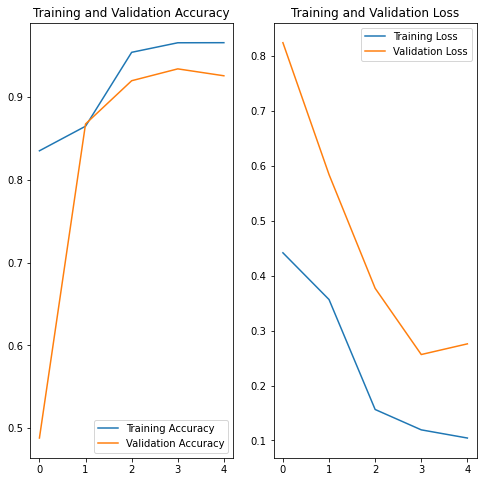

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

학습 후 weight. 학습 전 weight와 비교하여 달라졌음을 볼 수 있습니다. 즉, CNN이 학습되는 과정은 수많은 weigt를 학습하면서 모델이 예측에 필요한 feature를 사용할 수 있는 방향으로 업데이트된다는 것을 의미합니다.

In [24]:
print(model.layers[0].get_weights()) #after training

[array([[[[-6.09562136e-02, -1.31874204e-01,  4.91300635e-02,
          -2.37113815e-02, -1.76412240e-01,  1.73083052e-01,
          -2.01113261e-02,  1.07613906e-01, -6.58439845e-03,
          -5.15100285e-02,  1.92153901e-01,  9.56470147e-02,
          -1.01939149e-01,  7.99307153e-02, -1.35992482e-01,
          -4.09871191e-02],
         [-5.18068075e-02, -2.09405452e-01, -1.76462397e-01,
           8.56210515e-02, -1.85681090e-01,  9.44013447e-02,
          -1.72232851e-01,  5.62772714e-02,  5.71343601e-02,
           1.29357949e-01, -2.82217488e-02,  2.03224160e-02,
           3.65012437e-02, -2.04949722e-01, -6.57592118e-02,
          -1.68644473e-01],
         [ 1.64298743e-01, -2.09851533e-01, -1.19076498e-01,
           7.57758599e-03,  5.71241081e-02,  1.26889408e-01,
          -6.26177341e-02, -4.44892384e-02, -2.48759892e-03,
           3.84225622e-02,  1.78550228e-01, -1.27212495e-01,
           4.36739670e-03, -1.21449865e-01, -1.25342578e-01,
          -1.69584110e-01]],

학습 과정을 재설계하기 위하여 결과를 분석합니다. 아래의 표는 Confusion Matrix로, 세로 줄은 실제 값을, 가로 줄은 예측 값을 나타냅니다.

In [25]:
val_generator.reset()
val_prediction = model.predict(val_generator)
prediction = np.argmax(val_prediction, axis = 1)

In [26]:
prediction

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [27]:
cm = confusion_matrix(prediction, val_generator.labels)
print(cm)

[[2444   31]
 [ 378 2659]]


In [ ]:
from sklearn.metrics import classification_report
target_name = ['Parasitiezed', 'Uninfected']
print(classification_report(val_generator.labels, prediction, target_names = target_name))